In [1]:
import plotly.express as px
import numpy as np
import pandas as pd
# import plotly.graph_objects as go

In [2]:
#Load initial data
dat = pd.read_csv('Covid19_Data.csv', index_col = 0)
dat.index = pd.to_datetime(dat.index)

In [3]:
#Housekeeping to make into multiindex.
col = dat.columns.str.split('_', expand=True)
dat.columns = col
dat.index = dat.index.rename("Date")
dat.columns = dat.columns.rename(['Country', 'Col'])
dat = dat.stack(level=0)
dat.index = dat.index.reorder_levels(['Country', 'Date'])

In [4]:
def get_JHU_data(name):
    jhu_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_{}_global.csv'.format(name)
    jhu_df = pd.read_csv(jhu_url, error_bad_lines = False)

    jhu_df = jhu_df.groupby('Country/Region').sum().drop(['Lat', 'Long'], axis=1)
    jhu_df = jhu_df.stack().rename(name.capitalize()).to_frame()

    jhu_df.index = jhu_df.index.rename(['Country', 'Date'])
    jhu_df.index = jhu_df.index.set_levels([jhu_df.index.levels[0], pd.to_datetime(jhu_df.index.levels[1])])

    return jhu_df

In [5]:
def get_us_data():
    url = 'https://covidtracking.com/api/us/daily.csv'
    us_df = pd.read_csv(url, index_col = 0)
    us_df.index = pd.to_datetime(us_df.index, format = '%Y%m%d').rename('Date')
    us_df = us_df.sort_index()
        
    col_map = {
        'positive': 'Confirmed',
        'totalTestResults': 'TotalTests',
        'hospitalized': 'Hospitalized',
        'death': 'Deaths'
    }
    
    us_df = us_df[list(col_map.keys())].rename(mapper=  col_map, axis=1)    
    us_df['Country'] = 'US'
    us_df = us_df.set_index([us_df.Country, us_df.index]).drop(['Country'], axis=1)
    
    return us_df

In [6]:
def get_italy_data():
    url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
    italy_df = pd.read_csv(url, index_col = 0)
    italy_df.index = pd.to_datetime(italy_df.index).normalize().rename('Date')
    col_map = {
        'dimessi_guariti': 'Recovered',
        'totale_ospedalizzati': 'Hospitalized',
        'isolamento_domiciliare': 'Home',
        'tamponi': 'TotalTests',
        'stato': 'Country',
        'totale_casi': 'Confirmed',
        'deceduti': 'Deaths'
    }
    italy_df = italy_df[list(col_map.keys())].rename(mapper =  col_map, axis=1)
    italy_df.Country = 'Italy'
    italy_df = italy_df.set_index([italy_df.Country, italy_df.index]).drop(['Country'], axis=1)

    return italy_df

In [7]:
def join_dfs(default, other):
    #For joining dataframes, using one as default and filling in missing data
    overlap = set(default.columns).intersection(set(other.columns))
    default = pd.merge(default, other, left_index=True, right_index = True, how = 'outer', suffixes = ('', '_other'))
    for col in overlap:
        default[col] = default[col].combine_first(default[col + '_other'])
    
    default = default.drop([col + '_other' for col in overlap], axis=1)
    
    return default
        

In [8]:
def get_pop_dict():
    pop = pd.read_csv('WPP2019_TotalPopulationBySex.csv')
    pop = pop[pop.Time.eq(2020) & pop.Variant.eq('Medium')][['Location', 'PopTotal']].set_index('Location')
    pop.columns = ['Population']
    pop.loc['Diamond Princess'] = 3700
    
    aliases = {
        'US': 'United States of America',
        'Iran': 'Iran (Islamic Republic of)',
        'Bolivia': 'Bolivia (Plurinational State of)',
        'Brunei': 'Brunei Darussalam',
        'Korea, South': 'Republic of Korea',
        'Moldova': 'Republic of Moldova',
        'Russia': 'Russian Federation',
        "Cote d'Ivoire": "Côte d'Ivoire",
        'Syria': 'Syrian Arab Republic',
        'Tanzania': 'United Republic of Tanzania',
        'West Bank and Gaza': 'State of Palestine',
        'Venezuela': 'Venezuela (Bolivarian Republic of)',
        'Vietnam': 'Viet Nam',
        'Taiwan*': 'China, Taiwan Province of China',
        'Congo (Brazzaville)': 'Congo',
        'Congo (Kinshasa)': 'Democratic Republic of the Congo'
    }
    
    aliases = {v:k for k, v in aliases.items()}
    pop = pop.rename(mapper = aliases, axis=0) * 1000
    return pop

def merge_pop(df):
    pop = get_pop_dict()
    df = df.merge(pop, how = 'left', left_on = 'Country', right_index = True)
    return df

In [9]:
jhu_df = get_JHU_data('confirmed')
jhu_death_df = get_JHU_data('deaths')
jhu_df = jhu_death_df.join(jhu_df)
jhu_death_df = None

In [10]:
dat = join_dfs(dat, get_us_data())
dat = join_dfs(dat, get_italy_data())
dat = join_dfs(dat, jhu_df)
jhu_df = None
dat = merge_pop(dat)

In [11]:
def get_divide_cols_fn(c1, c2, res):
    def f(df):
        df[res] = df[c1]/df[c2]
        return df
    return f


## TODO:
#### Stats to Add:
* DONE: Death Rate
* DONE: 
* Hospitalization Rate
* Per capita testing (probably have to include as a separate graph bc x-axis)
    * Need to get API for population retrieval, definitely can get this.

#### Other things todo:
* Add lockdown date in graphs (maybe a star)
* Refresh data button? Should just run the data_clean script.


In [12]:
#Tens of thousands of population
dat['Pop10k'] = dat['Population'] / 10000

#Add New Cases, New Tests
dat['NewCases'] = dat.groupby('Country')['Confirmed'].diff()
dat['NewTests'] = dat.groupby('Country')['TotalTests'].diff()
dat['DaysSinceFirst'] = (dat['Confirmed'] >= 1).groupby('Country').cumsum().replace(0, np.nan) - 1
dat['ConfirmedGrowth'] = dat.groupby('Country')['Confirmed'].pct_change() * 100.
dat['DaysSinceTenthDeath'] = (dat['Deaths'] >= 10).groupby('Country').cumsum().replace(0, np.nan)
# dat['DaysSinceShutdown'] = dat['Shutdown'].groupby('Country').fillna(method='ffill').groupby('Country').cumsum().replace(0, np.nan) - 1


dat = dat.groupby('Country').apply(get_divide_cols_fn("NewCases", "NewTests", "DailyPosTestRate"))
dat = dat.groupby('Country').apply(get_divide_cols_fn("Confirmed", "TotalTests", "CumulativePosTestRate"))
dat = dat.groupby('Country').apply(get_divide_cols_fn("Deaths", "Confirmed", "CumulativeDeathRate"))
dat = dat.groupby('Country').apply(get_divide_cols_fn('Hospitalized', 'Confirmed', 'HospitalizationRate'))
dat = dat.groupby('Country').apply(get_divide_cols_fn('TotalTests', 'Pop10k', 'TotalTestsPer10k'))

In [13]:
dat['DaysSinceShutdown'] = np.nan
x = (dat[dat['Shutdown'] == 1]).groupby('Country').shift(0)
s_countries = list(x.index.get_level_values(0))

for s in s_countries:
    #Find d
    old = x.xs(s, level=0)
    d = (old.index[x['Shutdown'] == 1] - dat.index[0][1]).days[0]
    new = dat.xs(s, level=0).Shutdown.shift(-d+2).fillna(1).cumsum() - (d-1)
    dat.loc[s]['DaysSinceShutdown'] = new

In [14]:
# dat.loc['Peru']['DaysSinceShutdown'].tail(15)
dat = dat[dat['Confirmed'] >= 1]
# s_countries

In [15]:
dat.tail(10)

dat = dat.set_index([dat.index, "DaysSinceFirst", "DaysSinceTenthDeath", "DaysSinceShutdown"
                    ]).reorder_levels(["Country", "DaysSinceFirst", "DaysSinceTenthDeath", "DaysSinceShutdown",
                                       "Date"]).sort_index()

In [16]:
dat.tail(30)

countries = list(dat.index.get_level_values(0).unique())
stats = list(dat.columns)
stat_map = {
    'DailyPosTestRate': 'Daily Positive Test Rate',
    'Confirmed': 'Confirmed Tests',
    'NewTests': 'Daily New Tests',
    'CumulativePosTestRate': 'Cumulative Positive Test Rate',
    'NewCases': 'New Cases',
    'TotalTests': 'Total Tests',
    'ConfirmedGrowth': 'Daily Confirmed Cases Growth (%)',
    'CumulativeDeathRate': 'Cumulative Death Rate',
    'HospitalizationRate': 'Hospitalization Rate',
    'TotalTestsPer10k': 'Total Tests per 10k Population'
}

xs = ['DaysSinceFirst', 'Date', 'DaysSinceTenthDeath', 'DaysSinceShutdown']
xs_map = {'DaysSinceFirst': 'Days Since First Confirmed',
         'DaysSinceTenthDeath': 'Days Since 10th Death',
         'DaysSinceShutdown': 'Days Since Economic Shutdown'}


# Important Dates by Country:

### Peru
- Sourhces: ministerio de salud, wikipedia page
* March 11 - Declaran emergencia sanitaria por 90 dias
* March 13 - Suspenden vuelos internacional desde Europa y Asia
* March 16 - Teletrabajo para todos menos los esenciales
* March 17 - Cierran fronteras
* March 18 - Cuarentena general entre 8PM y 5 AM.
* https://www.dge.gob.pe/portal/

### Panama
* Something

### Guatemala
- Source: Alejandro Giammattei twitter
* March 22 - Cuarentena general entre 4 PM y 4 AM por 8 dias

In [17]:
def make_graph(count_to_plot, stat_to_plot, x_axis, plot_style = 0, m=None):
    to_add = ['Date'] if x_axis != 'Date' else []
    to_plot = dat.reset_index()
    to_plot = to_plot[to_plot.Country.isin(count_to_plot)][['Country'] + [stat_to_plot] + [x_axis] + ['Shutdown']+to_add ]
    if x_axis != 'Date':
        to_plot['Date'] = to_plot['Date'].dt.strftime('%b %d, %Y')
#     to_plot.Shutdown = to_plot.Shutdown.fillna(method  = 'ffill')
    to_plot.Shutdown = to_plot.Shutdown.fillna(value = 0)
    
#     to_plot = to_plot.dropna(axis=0, how = 'any')
    print(to_plot.head())

    
    if plot_style == 0:
        fig = px.scatter(to_plot, 
                         x = to_plot[x_axis], 
                         y = to_plot[stat_to_plot], 
                         color = to_plot.Country,
                         hover_data = ['Date'] if x_axis != 'Date' else [],
#                          symbol = 'Shutdown',
#                          symbol_map = {1: 'star', 0:'circle'},
                         title = '{} by Country'.format(stat_map.get(stat_to_plot, stat_to_plot)))
    elif plot_style == 1:
        fig = px.bar(to_plot, 
                         x = to_plot[x_axis], 
                         y = to_plot[stat_to_plot], 
                         color = to_plot.Country,
                         barmode = 'group',
                         hover_data = ['Date'] if x_axis != 'Date' else [],
                         title = '{} by Country'.format(stat_map.get(stat_to_plot, stat_to_plot)))
    elif plot_style == 2:
        fig = px.line(to_plot, 
                         x = to_plot[x_axis], 
                         y = to_plot[stat_to_plot], 
                         color = to_plot.Country,
                         hover_data = ['Date'] if x_axis != 'Date' else [],
                         title = '{} by Country'.format(stat_map.get(stat_to_plot, stat_to_plot)))
#     fig.add_trace(tr)
    
#     fig.update_xaxes(title = 'Days Since First Confirmed Test')
    fig.update_xaxes(title = xs_map.get(x_axis, x_axis))
    fig.update_yaxes(title = stat_to_plot)
    
#     for trace in fig.data:
#         trace.name = trace.name.split(',')[0]
    
    if m is not None:
        x_lim = to_plot.reset_index().groupby('Country')[x_axis].max().min() * m
        y_lim = to_plot.reset_index().groupby('Country')[stat_to_plot].max().min() * m
        fig.update_xaxes(range = [0, x_lim])
        fig.update_yaxes(range = [0, y_lim])
        
    return fig



     Country  Confirmed  DaysSinceShutdown  Shutdown          Date
2964  Panama        1.0               -8.0       0.0  Mar 09, 2020
2965  Panama        8.0               -7.0       0.0  Mar 10, 2020
2966  Panama       14.0               -6.0       0.0  Mar 11, 2020
2967  Panama       27.0               -5.0       0.0  Mar 12, 2020
2968  Panama       36.0               -4.0       0.0  Mar 13, 2020


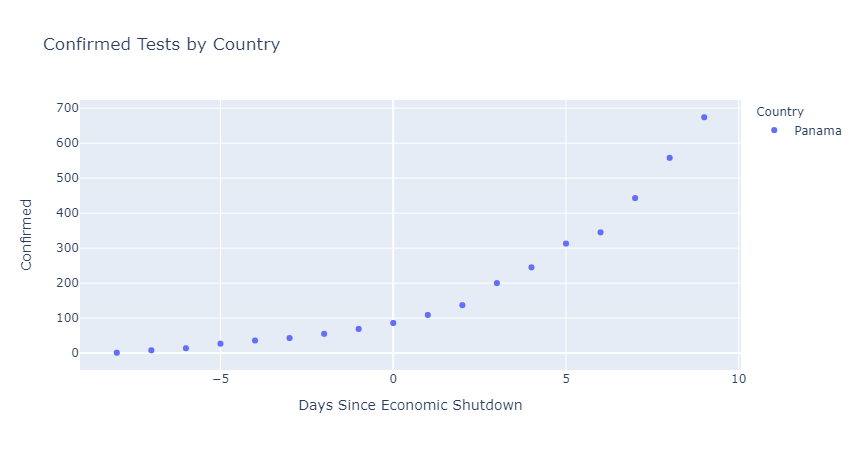

In [19]:
count_to_plot = ['Panama']
y_to_plot =  'Confirmed'
x_lab = 'DaysSinceShutdown'
x_axis = x_lab
stat_to_plot = y_to_plot
f = make_graph(count_to_plot, y_to_plot, x_lab, plot_style=0)
f

In [28]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from jupyter_plotly_dash import JupyterDash
# import jupyterlab_dash

In [29]:
# viewer = jupyterlab_dash.AppViewer()
# app = dash.Dash('Covid-Tracking')
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = JupyterDash('Covid-Tracking')

In [30]:
app.layout = html.Div([
    html.Div([
        html.H2('COVID-19 Tracking',),
        html.H4('Please hit "Reset axis" button after changing x-axis on plots; button in top right corner of each plot, shaped like house.'),
        html.H4('You can also pan, zoom, and hover over datapoints in the plots.')
    ]),
    html.Div([    
        html.P(["Countries:", 
            dcc.Dropdown(
                id = 'country-select',
    #             options = countries,
                options = [{'label': stat_map.get(c, c), 'value': c} for c in countries],
                value = ['Panama'],
                multi = True
            )
        ]),
    ], style = {"width": "30%", 'display': 'inline-block', 'text-align': 'center'} ),
    html.Div([
        html.P(["Statistics:",
            dcc.Dropdown(
                id = 'statistic-select',
                options = [{'label': stat_map.get(s, s), 'value': s} for s in stats],
                value = ['Confirmed'],
                multi=True
            )
        ])
    ], style = {'width':'30%', 'display':'inline-block', 'text-align': 'center'}),
    html.Div([
        html.P(["X-Axis:",
            dcc.Dropdown(
                id = 'x-axis-select',
                options = [{'label': xs_map.get(x, x), 'value': x} for x in xs],
                value = 'DaysSinceFirst',
                multi=False
            )
        ])
    ], style = {'width':'20%', 'display':'inline-block', 'text-align': 'center'}),
    html.Div([
        html.P(["Graph Style:",
            dcc.Dropdown(
                id = 'graph-style',
                options = [{'label': 'Scatter', 'value': 0}, 
                           {'label': 'Bar' , 'value': 1},
                           {'label': 'Line', 'value': 2}],
                value = 0,
                multi=False
            )
        ])
    ], style = {'width':'20%', 'display':'inline-block', 'text-align': 'center'}),
    
    html.Div(children = html.Div(id='graphs'), className = 'row', style = {"display":'inline-block', 'width': '100%'}),

    html.Div([
        html.P(['Most data on confirms and deaths from Johns Hopkins. US data from covidtracking.com, Italy data from official repo. Other data independently gathered']),
    ])
#     dcc.Graph(id='graphs', style = {'width': '80%', 'display': 'inline-block'}),
], className = 'container'
)


@app.callback(
    dash.dependencies.Output('graphs', 'children'),
    [dash.dependencies.Input('country-select', 'value'), dash.dependencies.Input('statistic-select', 'value'),
    dash.dependencies.Input('x-axis-select', 'value'), dash.dependencies.Input('graph-style', 'value')]
)
def update_graph(countries, stats, x_axis, graph_style):
    if len(stats)>2:
        class_choice = 'col s12 m6 l4'
    elif len(stats) == 2:
        class_choice = 'col s12 m6 l6'
    else:
        class_choice = 'col s12'
    #Returns a list of graphs
    graphs = []
#     return make_graph(countries, stats[0], scatter=False)
    for plot_stat in stats:
        g = make_graph(countries, plot_stat, x_axis, plot_style=graph_style)
        graphs.append(html.Div(dcc.Graph(
            id = plot_stat,
            animate = True,
            figure = g        
            ), className = class_choice
        ))
    return graphs
# viewer.show(app)

In [31]:
app

In [160]:

# pop.index = pop.index.rename(mapper = aliases)
# pop.tail(50)
# aliases

In [157]:
# x = dat.unstack()

# x.Population = get_pop(pop, list(x.index))



In [158]:
x.loc['US']

,Confirmed,Deaths,Home,Hospitalized,ICU,Shutdown,TotalTests,Recovered,NewCases,NewTests,DaysSinceFirst,ConfirmedGrowth,DaysSinceTenthDeath,DailyPosTestRate,CumulativePosTestRate,CumulativeDeathRate,Population
Date,,,,,,,,,,,,,,,,,
2020-01-22,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,331002.647
2020-01-23,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,0.000000,NaN,NaN,NaN,0.000000,331002.647
2020-01-24,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,100.000000,NaN,NaN,NaN,0.000000,331002.647
2020-01-25,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,3.0,0.000000,NaN,NaN,NaN,0.000000,331002.647
2020-01-26,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,4.0,150.000000,NaN,NaN,NaN,0.000000,331002.647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-22,31879.0,398.0,NaN,2554.0,NaN,NaN,225342.0,NaN,8682.0,46236.0,60.0,37.427254,19.0,0.187776,0.141469,0.012485,331002.647
2020-03-23,42152.0,471.0,NaN,3325.0,NaN,NaN,279473.0,NaN,10273.0,54131.0,61.0,32.224976,20.0,0.189780,0.150827,0.011174,331002.647
2020-03-24,51954.0,675.0,NaN,4468.0,NaN,NaN,344712.0,NaN,9802.0,65239.0,62.0,23.253938,21.0,0.150248,0.150717,0.012992,331002.647
